In [1]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import matplotlib
import glob
import skimage.io as skio
from sklearn.model_selection import train_test_split
import xgboost as xgb
import os
from scipy import interpolate
from scipy.signal import medfilt
from scipy.signal import find_peaks
import pandas as pd
from scipy.ndimage import uniform_filter1d
import math

matplotlib.rcParams['figure.figsize'] = [20, 20]

In [2]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [3]:
# path = "/mnt/external.data/TowbinLab/kstojanovski/"

# datafolders = []
# for file in os.listdir(path):
#     d = os.path.join(path, file)
#     if os.path.isdir(d):
#         if len(glob.glob(d + "/analysis/report/" + "*" + "str_molts_nw_cor.mat")) > 0:
#             d = d + "/analysis/report/"
#             datafolders.append(d)
# # datafolders.remove("/mnt/external.data/TowbinLab/kstojanovski/20220617_Ti2_10x_wBT182_IAAtitrat_25C_20220617_170453_440/analysis/report/")

# print(len(datafolders))

0


/tmp/ipykernel_1657628/3635707134.py:61: RuntimeWarning: overflow encountered in long_scalars
  error.append(m[3] - m4[1])


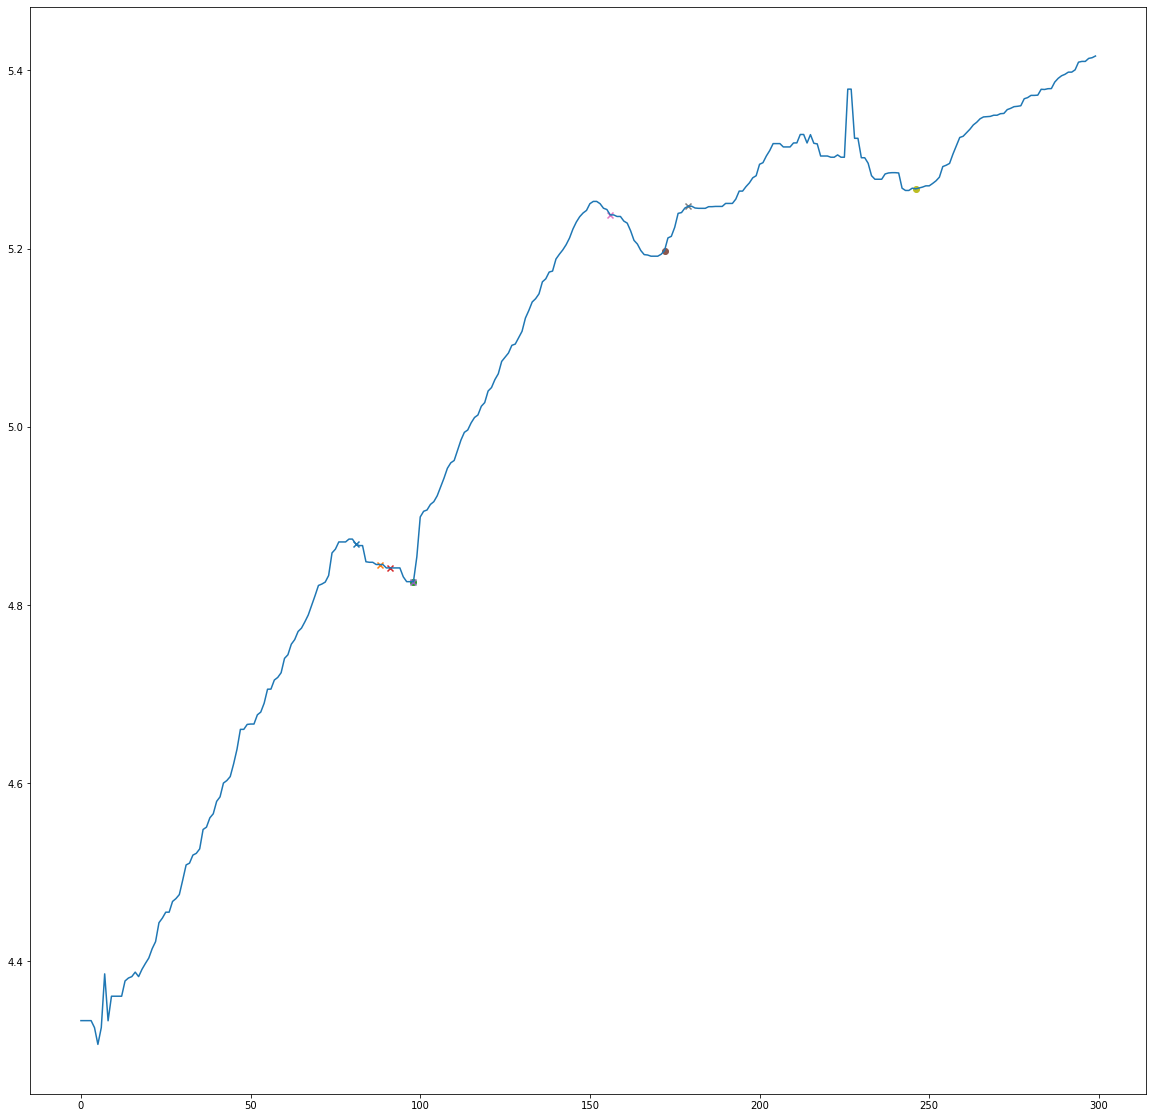

1


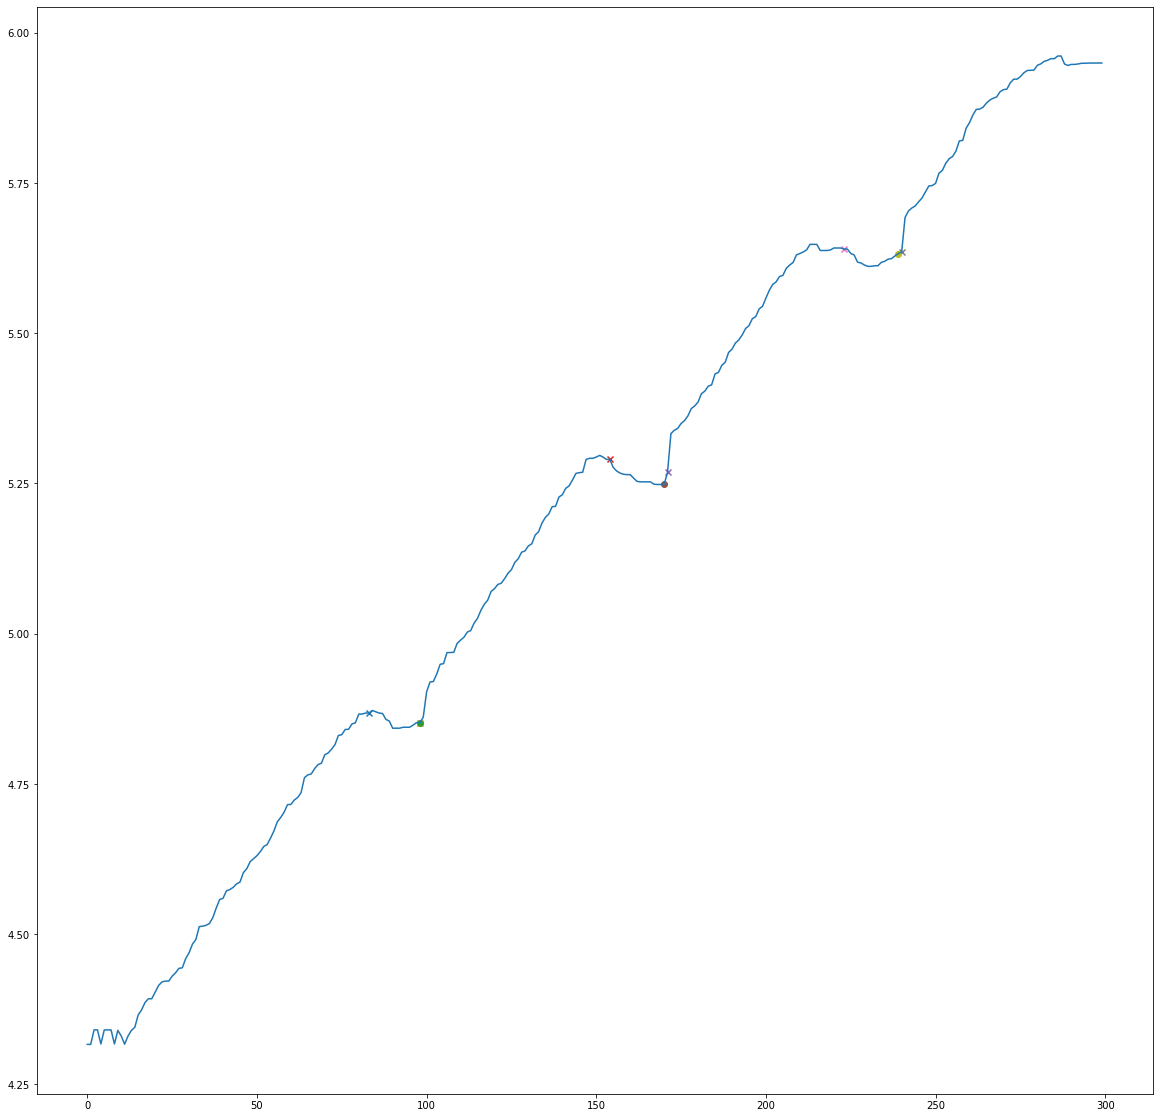

2


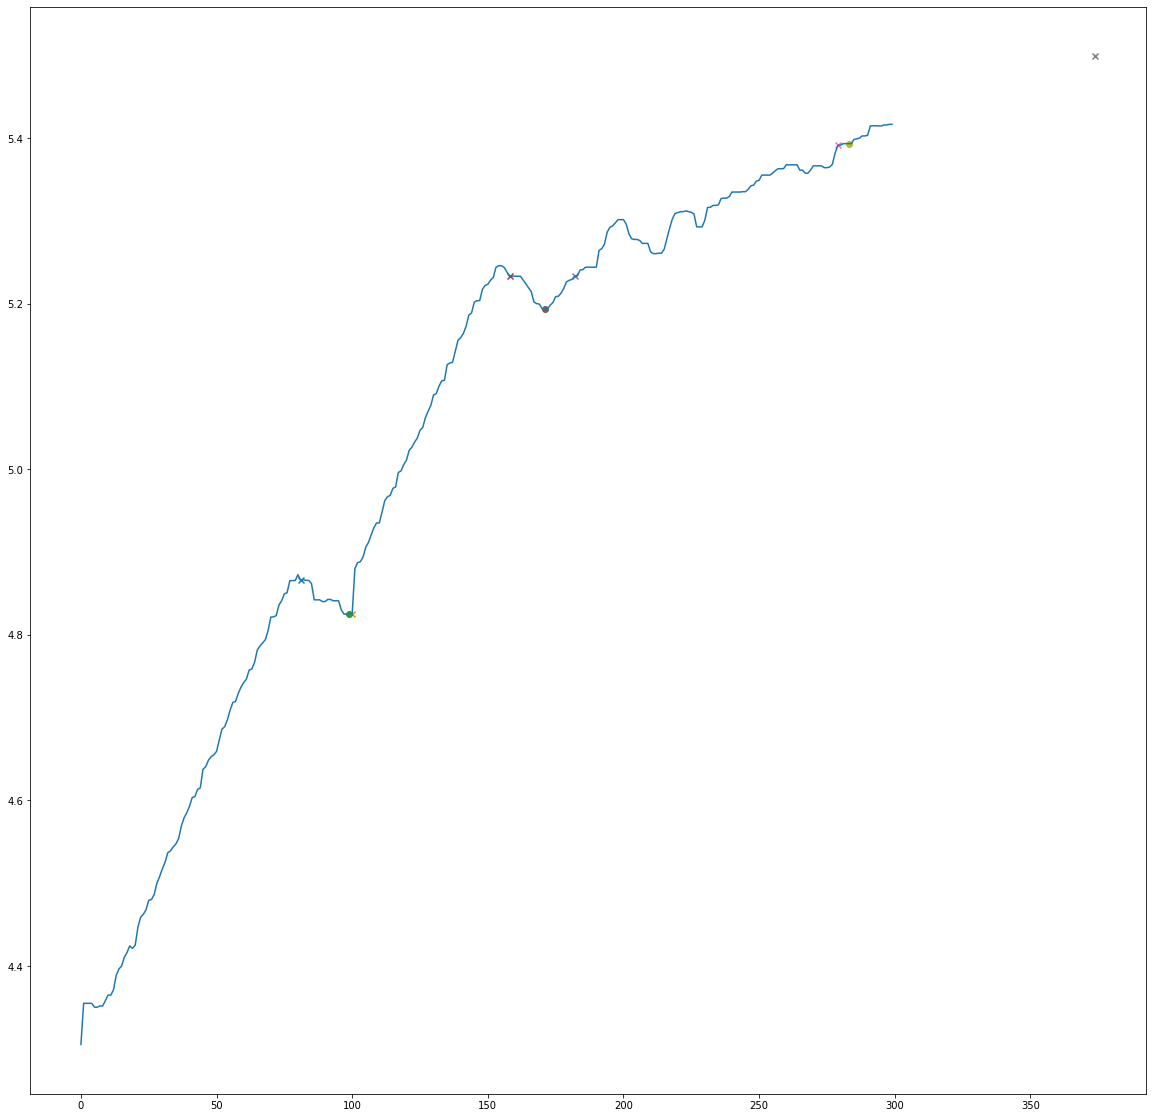

KeyError: 3

In [14]:
report_folder = "/mnt/external.data/TowbinLab/kstojanovski/20220819_Ti2_10x_RNAi_wBT160-186_25C_20220819_162820_807/analysis/report/"
# output_csv = report_folder + "moults.csv"
# output_csv = "./moults.csv"
file = glob.glob(report_folder + "*" + "ch2_sobel_str_molts_nw_cor.mat")[0]

moults_dataframe = pd.read_csv(output_csv)

# print(moults_dataframe)
mat = scipy.io.loadmat(file)

vol = mat['vol']
moults = mat['ecdys'][:, 1:]

counter = 0

error = []
for p, v in enumerate(vol[:40]):
    m = moults[p, :]
    m = m.astype(int)
    line = moults_dataframe.loc[p]
    print(p)
    # print(p)

    m1 = np.asarray((line[1], line[2])).astype(int)
    m2 = np.asarray((line[3], line[4])).astype(int)
    m3 = np.asarray((line[5], line[6])).astype(int)
    m4 = np.asarray((line[7], line[8])).astype(int)


    v = medfilt(v, 5)
    log_v = np.log10(v)

    nans, x= nan_helper(log_v)
    log_v[nans]= np.interp(x(nans), x(~nans), log_v[~nans])

    plt.plot(log_v[:300])

    plt.scatter(m1[0], log_v[m1[0]], marker = "x")
    plt.scatter(m1[1], log_v[m1[1]], marker = "x")
    plt.scatter(m[0], log_v[m[0]])

    plt.scatter(m2[0], log_v[m2[0]], marker = "x")
    plt.scatter(m2[1], log_v[m2[1]], marker = "x")
    plt.scatter(m[1], log_v[m[1]])

    plt.scatter(m3[0], log_v[m3[0]], marker = "x")
    plt.scatter(m3[1], log_v[m3[1]], marker = "x")
    plt.scatter(m[2], log_v[m[2]])

    # plt.scatter(m4[0], log_v[m4[0]], marker = "x")
    # plt.scatter(m4[1], log_v[m4[1]], marker = "x")
    # plt.scatter(m[3], log_v[m[3]])

    if not (math.isnan(m1[1])) and not (math.isnan(m[0])):
        error.append(m[0] - m1[1])
    if not (math.isnan(m2[1])) and not (math.isnan(m[1])):
        error.append(m[1] - m2[1])
    if not (math.isnan(m3[1])) and not (math.isnan(m[2])):
        error.append(m[2] - m3[1])
    if not (math.isnan(m4[1])) and not (math.isnan(m[3])):
        error.append(m[3] - m4[1])


    plt.show()

error = np.abs(error)

# plt.plot(error)

# print(error)
print("mean error :", np.mean(error))
print("median error :", np.median(error))
        

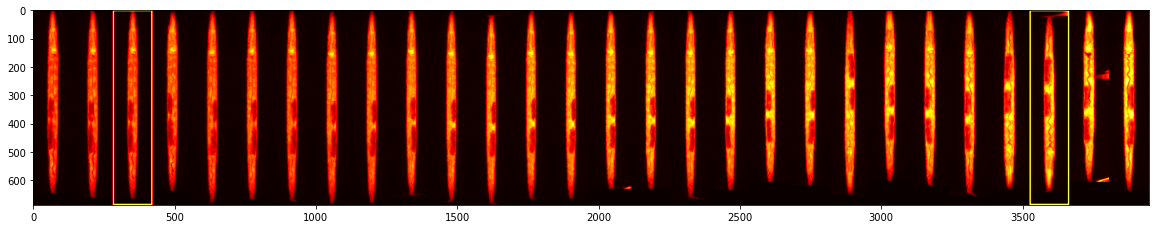

In [15]:
import tifffile as ti
# str_fluo_folder = "/mnt/external.data/TowbinLab/kstojanovski/20220221_Ti2_10x_wBT160-263-182-258_25C_20220221_170003_134/analysis/ch2_raw_str/"
str_fluo_folder = "/mnt/external.data/TowbinLab/kstojanovski/20220819_Ti2_10x_RNAi_wBT160-186_25C_20220819_162820_807/analysis/ch2_raw_str/"
# output_dir = "/mnt/external.data/TowbinLab/kstojanovski/20220221_Ti2_10x_wBT160-263-182-258_25C_20220221_170003_134/analysis/images_of_moult/"
def create_demo_image(point, moult):
    beg, end = moult
    # to_plot = [beg-2, beg - 1, beg, beg + 1, (beg+end)//2, end - 1, end, end + 1, end + 2]
    to_plot = range(beg-2, end+3)
    max_height = 0
    for i in to_plot:
        time = str(int(i))
        while len(time) < 5:
            time = "0"+time
        time_point = "Time"+time+"_Point"+point
        str_fluo_file = glob.glob(str_fluo_folder+time_point+"*")[0]

        im = ti.imread(str_fluo_file).T
        
        if im.shape[0] > max_height:
            max_height = im.shape[0]
    
    # img = np.zeros((max_height, 141))
    for i in to_plot:
        if i == to_plot[0]:
            time = str(int(i))
            while len(time) < 5:
                time = "0"+time
            time_point = "Time"+time+"_Point"+point
            str_fluo_file = glob.glob(str_fluo_folder+time_point+"*")[0]

            im = ti.imread(str_fluo_file).T

            to_concat = np.zeros((max_height, 141))

            to_concat[0:im.shape[0], :] = im
            img = to_concat
        else:
            time = str(int(i))
            while len(time) < 5:
                time = "0"+time
            time_point = "Time"+time+"_Point"+point
            str_fluo_file = glob.glob(str_fluo_folder+time_point+"*")[0]

            im = ti.imread(str_fluo_file).T

            if (np.unravel_index(im.argmax(), im.shape))[0] > im.shape[0]//2:
                im = np.flip(im, axis = 0)

            to_concat = np.zeros((max_height, 141))

            to_concat[0:im.shape[0], :] = im

            if i == beg or i == end:
                to_concat[0:5, :] = np.max(im)
                to_concat[max_height-5:max_height, :] = np.max(im)
                to_concat[:, 0:5] = np.max(im)
                to_concat[:, 141-5:141] = np.max(im)
            img = np.concatenate((img, to_concat), axis = 1)
    plt.imshow(img, cmap="hot")
    plt.show()

# p = 14
# p=5
# p = 8
p = 0

point = str(p)

while len(point) < 4:
    point = "0"+point

line = moults_dataframe.loc[p]

m1 = np.asarray((line[1], line[2])).astype(int)
m2 = np.asarray((line[3], line[4])).astype(int)
m3 = np.asarray((line[5], line[6])).astype(int)
m4 = np.asarray((line[7], line[8])).astype(int)

create_demo_image(point, m3)

218


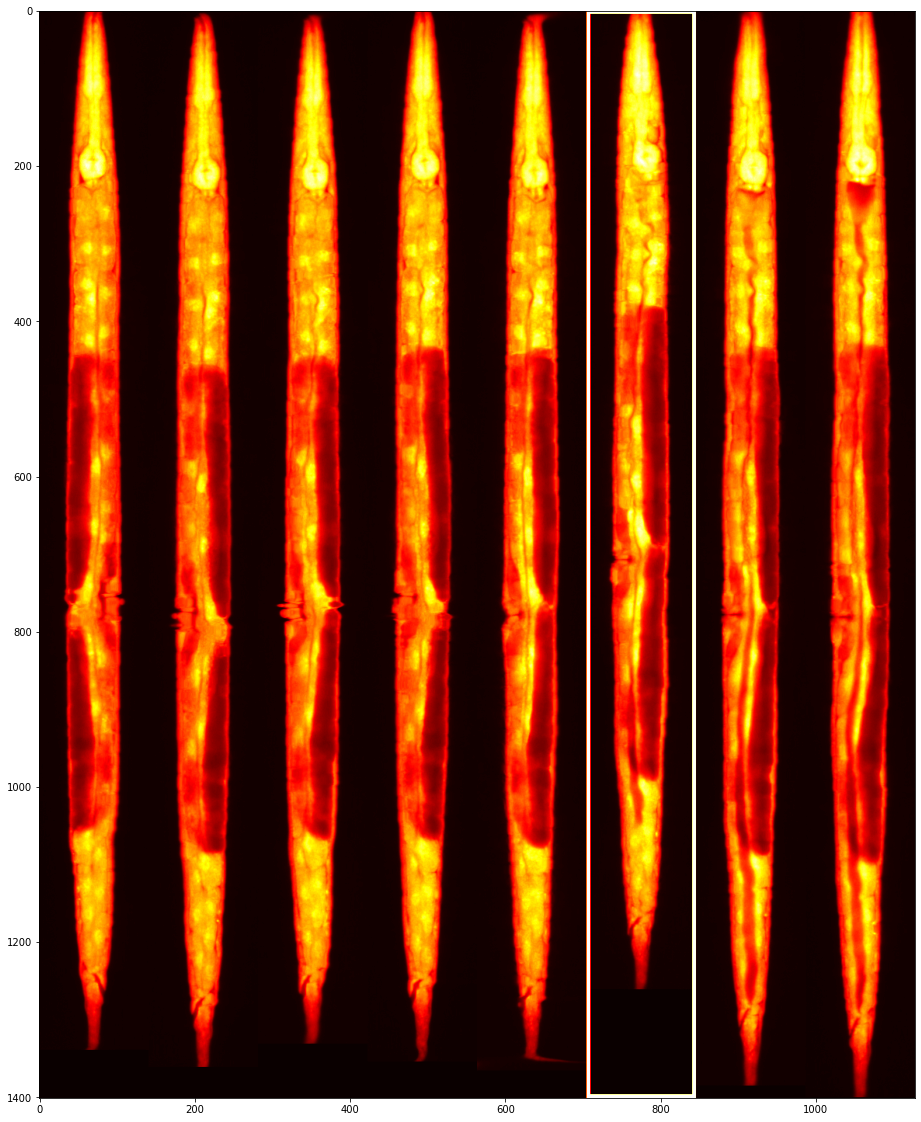

In [ ]:
def create_demo_image_data(point, moults, moult):
    moults = [moults[moult - 1]]
    for moult in moults :
        print(moult)
        to_plot = range(moult-5, moult+3)
        max_height = 0
        for i in to_plot:
            time = str(int(i))
            while len(time) < 5:
                time = "0"+time
            time_point = "Time"+time+"_Point"+point
            str_fluo_file = glob.glob(str_fluo_folder+time_point+"*")[0]

            im = ti.imread(str_fluo_file).T
            
            if im.shape[0] > max_height:
                max_height = im.shape[0]
        
        # img = np.zeros((max_height, 141))
        for i in to_plot:
            if i == to_plot[0]:
                time = str(int(i))
                while len(time) < 5:
                    time = "0"+time
                time_point = "Time"+time+"_Point"+point
                str_fluo_file = glob.glob(str_fluo_folder+time_point+"*")[0]

                im = ti.imread(str_fluo_file).T

                to_concat = np.zeros((max_height, 141))

                to_concat[0:im.shape[0], :] = im
                img = to_concat
            else:
                time = str(int(i))
                while len(time) < 5:
                    time = "0"+time
                time_point = "Time"+time+"_Point"+point
                str_fluo_file = glob.glob(str_fluo_folder+time_point+"*")[0]

                im = ti.imread(str_fluo_file).T

                if (np.unravel_index(im.argmax(), im.shape))[0] > im.shape[0]//2:
                    im = np.flip(im, axis = 0)

                to_concat = np.zeros((max_height, 141))

                to_concat[0:im.shape[0], :] = im

                if i == moult:
                    to_concat[0:5, :] = np.max(im)
                    to_concat[max_height-5:max_height, :] = np.max(im)
                    to_concat[:, 0:5] = np.max(im)
                    to_concat[:, 141-5:141] = np.max(im)
                img = np.concatenate((img, to_concat), axis = 1)
        plt.imshow(img, cmap="hot")
        plt.show()

# p = 8
# p = 13
p=52

point = str(p)

while len(point) < 4:
    point = "0"+point

m = moults[p, :].astype(int)

# line = moults_dataframe.loc[p]

# m1 = (line[1], line[2])

# m2 = (line[3], line[4])

# m3 = (line[5], line[6])

# m4 = (line[7], line[8])

create_demo_image_data(point, m, 4)
# create_demo_image(point, m3)

In [ ]:
print(m3)

[175 184]
